## 🧠 Introducción

Este notebook corresponde al desarrollo de una prueba técnica para detectar posibles patrones de fraccionamiento de transacciones en Nequi. A partir de un conjunto masivo de datos con millones de transacciones, se plantearon hipótesis y se aplicaron tanto reglas estadísticas como modelos de machine learning no supervisado para detectar anomalías en ventanas móviles de 24 horas.

El objetivo principal fue identificar comportamientos sospechosos donde un usuario realiza múltiples transacciones con el mismo comercio en un periodo corto, lo cual puede representar una estrategia para evadir controles u ocultar montos significativos.


In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [2]:
ddf = dd.read_parquet('/content/sample_data_0006_part_00.parquet',
                      columns=None,
                      engine='pyarrow')  # pyarrow es por defecto

# Convierte a float64 (esto reduce la precisión pero evita el error)
ddf['transaction_amount'] = ddf['transaction_amount'].astype('float64')
# ——————————————————————————————
# Asegurar que la columna de fecha es datetime
# Esto es clave para poder usar ventanas de tiempo.
ddf['transaction_date'] = dd.to_datetime(ddf['transaction_date'])

In [3]:
# ——————————————————————————————
# 3. Convertir la fecha en índice
# Ponerla como índice permite aplicar métodos rolling basados en tiempo.
ddf = ddf.set_index('transaction_date').persist()
# persist() carga en memoria las particiones para acelerar las operaciones posteriores.

In [4]:
# ——————————————————————————————
# Ordenar cada partición por el índice temporal
# Rolling windows requieren que los datos estén en orden cronológico.
ddf = ddf.map_partitions(lambda df: df.sort_index())

In [5]:
fecha_min = ddf.index.min()
fecha_max = ddf.index.max()

# 2) Ejecuta solo esas dos tareas en paralelo:
min_val, max_val = dd.compute(fecha_min, fecha_max)

print("Fecha más antigua:", min_val)
print("Fecha más reciente:", max_val)

Fecha más antigua: 2021-01-01 00:01:13
Fecha más reciente: 2021-11-30 23:59:49


Debido a la dificultad de hacer esta prueba con todos los datos completos, opté por tomar una parte de los datos, desde 2021/03/01 hasta el 2021/06/30,  esto porque al hacer las distintas agrupaciones, transformaciones, gráficas y entrenamientos de modelos se hizo difícil debido a las limitancias computaciones de mi equipo personal; sin embargo, entiendo que en un ambiente profesional con servicios de nube se puede acceder a cómputo más sofisticado para realizar este tipo de análisis.

In [6]:
# Define tus fechas límite
fecha_inicio = '2021-03-01'
fecha_fin    = '2021-06-30'

# Como ya tienes transaction_date como índice:
ddf_periodo = ddf.loc[fecha_inicio:fecha_fin]

## Heurísticos y reglas basadas en ventana de tiempo.

Regla básica: en ventanas móviles de 24 horas, vamos a agrupar transacciones por misma user_id y mismo merchant_id ya que considero que también está incurriendo en fraccionamiento si un usuario desde distintas cuentas hace varias transacciones a un mismo destino, por eso hago estas agrupaciones con el usuario y Codigo de comercio/aliado, vamos a calcular número de transacciones y suma de montos; voy a flaggear cuando el conteo > 4 por el momento, pero más adelante emplearé técnicas estadísticas que me van a permitir toma una mejor referencia.


In [7]:
# ——————————————————————————————
# Calcular rolling count y sum en ventanas de 24 horas
rolling = (
    ddf_periodo
    .groupby(['user_id', 'merchant_id'])              # agrupar por cliente y comercio
    .transaction_amount                               # la serie sobre la que hago rolling
    .rolling('24h')                                   # ventana móvil de 24 horas
    .agg(['count', 'sum'])                            # calculo conteo y suma
    .reset_index()                                    # regreso a formato “tabla”
)

In [9]:
# Definir umbral y flaggear
#threshold = 0    # ajusta a tu criterio, p.ej. $1 000
flags = rolling[
    (rolling['count'] > 4)
#    & (rolling['sum']   > threshold)
]

In [10]:
# # “Pre-cacha” las particiones del resultado para acelerar accesos posteriores:
# flags = flags.persist()

In [11]:
flags.head(7)

,user_id,merchant_id,transaction_date,count,sum
0,d09912beaddd29f4ee0249bae64329ca,817d18cd3c31e40e9bff0566baae7758,2021-03-01 07:41:03,5.0,3269.450257
1,ca2acb38055362ea7544b1f872a4d5f8,817d18cd3c31e40e9bff0566baae7758,2021-03-01 08:03:51,5.0,594.445501
2,b2b7dc5b57f2079dee248e0f0d9d7075,817d18cd3c31e40e9bff0566baae7758,2021-03-01 08:04:07,5.0,1188.891002
3,5f5a8c1c37488e2c315e4a8851f8ef75,817d18cd3c31e40e9bff0566baae7758,2021-03-01 08:38:17,5.0,2972.227506
4,f797b32ea680de956ed80ab978948bc0,817d18cd3c31e40e9bff0566baae7758,2021-03-01 08:45:36,5.0,3150.561157
5,51539d36fdbaaa3f13ac6d0a604948e5,817d18cd3c31e40e9bff0566baae7758,2021-03-01 09:48:38,5.0,3566.673007
6,7349c41e437abe249ba3de1b574b9e90,817d18cd3c31e40e9bff0566baae7758,2021-03-01 09:55:17,5.0,3566.673007


In [12]:
# 3) Convierte a pandas únicamente las series que vas a plotear
#    (solo las dos columnas que necesitas)
sum_flags   = flags['sum'].compute()                   # suma acumulada en 24h para flagged
raw_amounts = ddf_periodo['transaction_amount'].compute()  # montos individuales

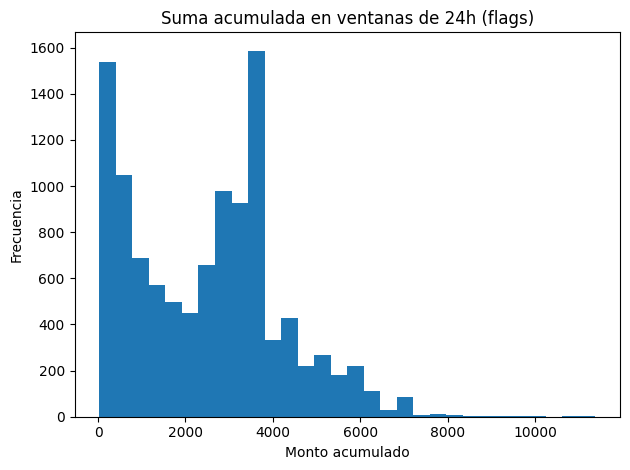

In [13]:
# Histograma de sumas acumuladas en las ventanas flagged
plt.figure()
plt.hist(sum_flags, bins=30)
plt.title('Suma acumulada en ventanas de 24h (flags)')
plt.xlabel('Monto acumulado')
plt.ylabel('Frecuencia')
plt.tight_layout()

Se observa una alta concentración de transacciones en varios puntos de los montos acomulados en ventanas móviles. Las distribuciones muestran que algunos usuarios superan por mucho los valores típicos de frecuencia o monto, se ve que la distribución es ***bimodal***, esto es sospecha de que hay dos poblaciones implícitas en los datos. Mi hipótesis es que la primera moda en su alrededor tiene personas que no tienden a fraccionar una transacción, mientras que los que están alrededor de la última moda podrian tender a fraccionar una transacción, esto porque ya son montos más grandes en más de 4 fracciones, lo cual es indicio potencial de fraccionamiento. Recordemos esta hipotesis más adelante de esta distribucion bimodal.


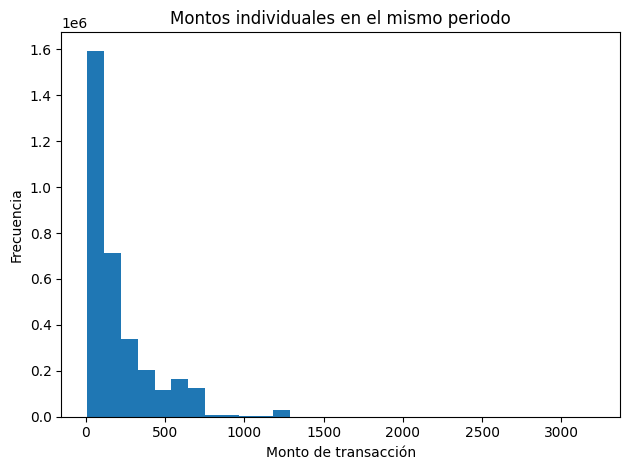

In [14]:
plt.figure()
plt.hist(raw_amounts, bins=30)
plt.title('Montos individuales en el mismo periodo')
plt.xlabel('Monto de transacción')
plt.ylabel('Frecuencia')
plt.tight_layout()


Vemos en este histograma que el resto de las transacciones, por lo general, son montos mucho más pequeños.

Ahora ¿Cómo evoluciona a lo largo del tiempo el número de ventanas marcadas como sospechosas?


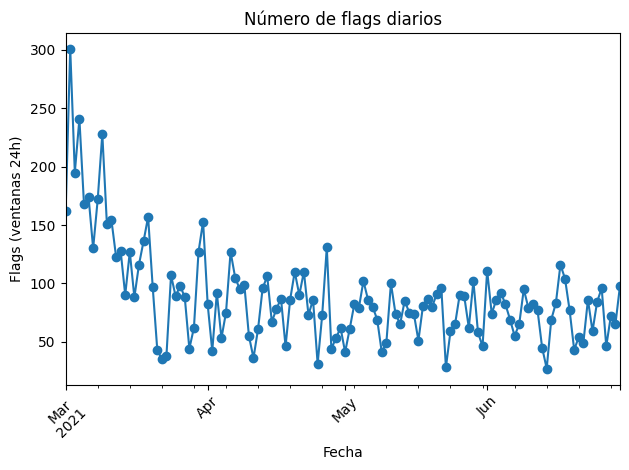

In [15]:
# 1) Asegúrate de que tienes transaction_date como columna
df_flags = flags.reset_index()

# 2) Crea la columna 'date' con solo la fecha (sin hora)
df_flags['date'] = df_flags['transaction_date'].dt.floor('D')

# 3) Agrupa por esa fecha y cuenta flags
flags_por_dia = (
    df_flags
    .groupby('date')
    .size()
    .compute()              # trae a pandas solo la serie de conteos diarios
)

# 4) Dibuja la serie
plt.figure()
flags_por_dia.plot(marker='o')
plt.title('Número de flags diarios')
plt.xlabel('Fecha')
plt.ylabel('Flags (ventanas 24h)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 Vemos que el número de banderas (flags) vienen de un aumento en marzo de 2021, esto tal vez puede estar asociado a que en ciertas temporadas del año es más usual ver este tipo de actividades de fraccionamiento de transacciones. No se pudo observar un historial más amplio debido a la limitación computacional de leer más datos y tener un historial por los millones de registros.    

In [16]:
df_flags.shape[0].compute()

10861

Conteo de flags por tipo de transacción:

In [17]:
#(reseteamos el índice para volver transaction_date en columna)
lookup = (
    ddf_periodo
    .reset_index()[['user_id','merchant_id','transaction_date','transaction_type']]
)

# Haz el merge con flags, uniéndolo por user_id, merchant_id y transaction_date
flags_with_type = flags.merge(
    lookup,
    on=['user_id','merchant_id','transaction_date'],
    how='left'
)

# Ahora sí puedes contar flags por tipo sin volver a hacer rolling
flags_tipo = flags_with_type['transaction_type'].value_counts().compute()


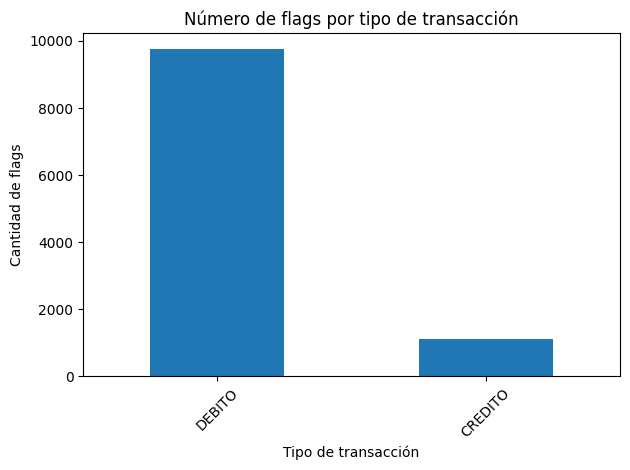

In [18]:
# flags_tipo es el pandas.Series: índice = transaction_type, valores = conteos
plt.figure()
flags_tipo.plot(kind='bar')
plt.title('Número de flags por tipo de transacción')
plt.xlabel('Tipo de transacción')
plt.ylabel('Cantidad de flags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La mayoría de los tipos de transacción, en los que marcamos como flags, son de tipo Débito y solo una pequeña parte de Crédito, mismo tipo de comportamiento en la data original, lo que no nos da muchos indicios de si esto es relevante a la hora de identificar cuando una transacción es fraccionada.

# Modelos estadísticos univariados:
Estos modelos univariados me permitirán saber qué número de transacciones en una ventana de tiempo es normal o atípico.

## Distribución Poisson:
Para modelar la frecuencia esperada de transacciones por usuario en 24 h; detectar como anomalías los recuentos que caen en la cola superior.

Un proceso de Poisson es un modelo estocástico de llegadas/eventos que satisface:

1. Independencia de intervalos disjuntos: el número de eventos en ventanas no traslapadas es independiente.

2. Tasa constante: la probabilidad de que ocurra un evento en un intervalo muy pequeño Δt es λ·Δt, con λ constante.

3. Sin “atascos”: la probabilidad de más de un evento en Δt tiende a cero más rápido que Δt.

Bajo estas condiciones, el conteo 𝑁(𝑡) de eventos en un intervalo de longitud 𝑡 sigue una distribución de Poisson con parámetro λt, donde λ es la tasa media de eventos por unidad de tiempo.

En nuestro caso:
- Eventos: cada transacción de un usuario (o de un usuario–comercio).

- Ventana: 24 horas, móvil o fija.

- Conteo
𝐶: número de transacciones en la ventana.

Asumimos que, para un mismo usuario, los eventos llegan de forma aproximadamente independiente y con una tasa “estable” a lo largo del tiempo (o al menos alrededor de la media). Esto justifica usar Poisson(𝜆) para modelar 𝐶.




In [19]:
# Asume que ya tienes ddf_periodo filtrado y:
rolled = (
    ddf_periodo
      .groupby('user_id','merchant_id')
      .transaction_amount
      .rolling('24h')
      .count()                                  # Series Dask con el conteo
      .to_frame('count')                        # la convierte en DataFrame y nombra la columna
      .reset_index()                            # ahora sí: index → columnas
)


In [20]:
# 1) Trae los counts a pandas
rolling_counts = rolled['count'].compute()

Lambda estimado (media móvil): 1.19
Umbral 99% (count >): 4
Primeras ventanas atípicas:
                            user_id    transaction_date  count
0  d09912beaddd29f4ee0249bae64329ca 2021-03-01 07:41:03    5.0
1  ca2acb38055362ea7544b1f872a4d5f8 2021-03-01 08:03:51    5.0
2  b2b7dc5b57f2079dee248e0f0d9d7075 2021-03-01 08:04:07    5.0
3  5f5a8c1c37488e2c315e4a8851f8ef75 2021-03-01 08:38:17    5.0
4  f797b32ea680de956ed80ab978948bc0 2021-03-01 08:45:36    5.0


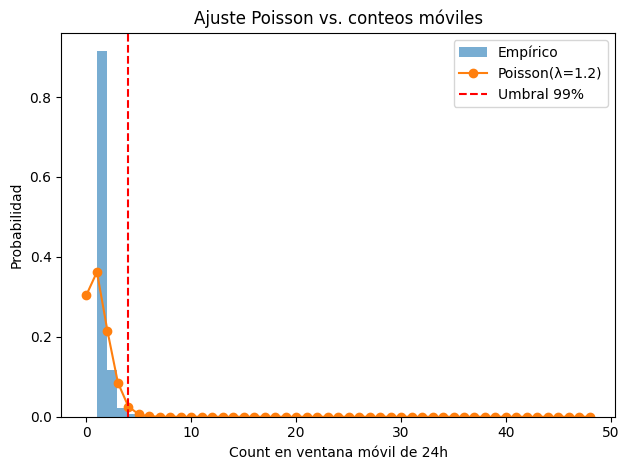

In [21]:
# 2) Estima lambda
lam = rolling_counts.mean()
print(f"Lambda estimado (media móvil): {lam:.2f}")

# 3) Umbral Poisson al 99 %
threshold = poisson.ppf(0.99, mu=lam)
print(f"Umbral 99% (count >): {threshold:.0f}")

# 4) Ventanas atípicas
anomalies = rolled[rolled['count'] > threshold].compute()
print("Primeras ventanas atípicas:")
print(anomalies.head())

# 5) Visualización del ajuste
plt.figure()
# Histograma empírico
plt.hist(rolling_counts, bins=50, density=True, alpha=0.6, label='Empírico')
# PMF teórica
x = range(0, int(rolling_counts.max())+1)
plt.plot(x, poisson.pmf(x, mu=lam), 'o-', label=f'Poisson(λ={lam:.1f})')
plt.axvline(threshold, color='r', linestyle='--', label='Umbral 99%')
plt.xlabel('Count en ventana móvil de 24h')
plt.ylabel('Probabilidad')
plt.title('Ajuste Poisson vs. conteos móviles')
plt.legend()
plt.tight_layout()
plt.show()


Aquí estamos identificando las observaciones en la cola superior de la distribución Poisson, donde la probabilidad de ocurrencia es ≤ 1 %.

En este caso, la probabilidad de ocurrencia después del humbral del 99% es cuando se tienen más de 4 transacciones en 24 horas. Este comportamiento no es usual y se detecta como dato atípico que podría interpretarse que después de este valor se está incurriendo en transacciones fraccionadas.   

## Detección de outliers en el número de transacciones (z-score)

En esta celda identificamos ventanas móviles de 24 h cuyo **conteo de transacciones** se sitúa muy lejos de la tendencia central, aplicando la regla clásica de **z-score**.

1. **Estimación de parámetros**  
   Calculamos la **media** y la **desviación estándar** de todos los valores de “count” obtenidos en las ventanas móviles. Estos dos valores resumen el comportamiento típico del número de transacciones en 24 h.

2. **Cálculo del z-score**  
   Para cada ventana, normalizamos su conteo restando la media y dividiendo entre la desviación estándar. El resultado es el **z-score**, que indica cuántas desviaciones estándar se aleja cada conteo de la media.

3. **Umbral de detección**  
   Fijamos un umbral de ±3 desviaciones estándar. Por convención, los datos con z-score mayor que +3 o menor que –3 se consideran atípicos en una distribución aproximada a la normal.

4. **Filtrado de outliers**  
   Seleccionamos únicamente las ventanas con z-score absoluto superior a 3. Estas son las sesiones de 24 h con un número de transacciones inusualmente alto (o bajo).

5. **Extracción e inspección**  
   Traemos a un DataFrame pandas solo esas filas outliers para explorarlas: verificamos `user_id`, fecha de la ventana y su z-score, con el fin de entender qué usuarios presentaron actividad excepcional en 24 h.

> **Nota:** El z-score es una técnica sencilla y rápida para detectar valores extremos sin necesidad de ajustar modelos complejos. Permite estandarizar variables y usar un umbral común (3 σ) para marcar anomalías.  


In [22]:
import dask.dataframe as dd

# Partimos de tu DataFrame Dask 'rolled' que ya tiene la columna 'count'

# 1) Calcula media y desviación estándar del conteo
mean_count, std_count = dd.compute(
    rolled['count'].mean(),
    rolled['count'].std()
)

# 2) Elige tu umbral de z-score (p.ej. 3σ)
z_thresh = 3

# 3) Crea la columna z_count
rolled = rolled.assign(
    z_count = (rolled['count'] - mean_count) / std_count
)

# 4) Filtra solo los outliers en el conteo
outliers_count = rolled[rolled['z_count'].abs() > z_thresh]

# 5) Trae a pandas únicamente las filas outliers para inspección
outliers_df = outliers_count.compute()

# 6) Inspecciona resultados
print(outliers_df[['user_id', 'transaction_date', 'count', 'z_count']].head())
print(f"Total outliers de count: {len(outliers_df):,}")

                              user_id    transaction_date  count   z_count
60   34bcad8fa8243725b18e6a6fad4c3033 2021-03-01 03:52:24    3.0  3.000530
303  b652707edf6aa8cfcb88211ce021f119 2021-03-01 07:07:44    3.0  3.000530
398  07872ca6c9dd3a7ef167d0a8563d5a4d 2021-03-01 07:22:35    3.0  3.000530
404  07872ca6c9dd3a7ef167d0a8563d5a4d 2021-03-01 07:23:22    4.0  4.656203
420  c927beee9825d06f49f6b953705eba79 2021-03-01 07:24:54    3.0  3.000530
Total outliers de count: 99,398


Segun el z-score es considerado atípico más de 3 transacciones en una misma ventana de 24 horas, lo que nos indica una regla que incluye a muchos más datos (99.398 casi 100 mil), lo que genera sospechas de si realmente serviría para tomar una regla de transacciones fraccionadas. Seguimos explorando a continuación más modelos  y reglas.

# Modelos de detección de anomalías multivariados
A continuación haré un poco de feature engineering para tener más características que pueda usar en modelos y algoritmos, aunque en estos modelos de detección de anomalías debido a sus características y naturalezas solo me va a servir para encontrar el número de transacciones que se consideran atípicos, ya que si añado por ejemplo la suma de los montos en estas transacciones se puede confundir con una transacción con un monto alto que es normal vs  varias transacciones que suman un mismo monto alto, ambos los identifican como atípicos por el monto, pero no es así, por eso emplearé solo el conteo de transacciones, pero luego observaremos como se comporta el resto de variables con estas reglas, definiremos quienes son estas variables en el primer punto del siguiente modelo.

## Detección de anomalías multivariadas con Isolation Forest

En esta sección entrenamos un modelo de **Isolation Forest** para identificar ventanas móviles de 24 h con comportamiento transaccional inusual, combinando métricas de volumen y ritmo de eventos.

1. **Extracción de features en Dask**  
   - A partir del DataFrame filtrado (`ddf_periodo`), calculamos en cada ventana:
     - **Conteo** de transacciones (`count_amt`)  
     - **Suma** de montos (`sum_amt`)  
     - **Media** y **desviación estándar** de los montos (`mean_amt`, `std_amt`)  
     - **Media** y **desviación estándar** del lapso de tiempo entre transacciones en **horas** (`mean_delta`, `std_delta`)  
   - Para evitar limitaciones de la API agrupamos y aplicamos dos `rolling.agg` separados (uno sobre montos y otro sobre deltas) y luego los unimos.

2. **Muestreo y conversión a pandas**  
   - Tomamos un **10 % aleatorio** de las filas resultantes y lo traemos a pandas, manteniendo representatividad sin sobrecargar memoria.  
   - Con esto obtenemos una tabla manejable de **cinco** variables numéricas por ventana:  
     ```
     [count_amt, sum_amt, mean_amt, std_amt, mean_delta, std_delta]
     ```

3. **Entrenamiento del Isolation Forest**  
   - Instanciamos `IsolationForest` con:
     - `n_estimators=100` (número de árboles)  
     - `contamination=0.01` (se asume ~1 % de anomalías)  
     - `random_state=42` (reproducibilidad)  
   - Ajustamos el modelo sobre la matriz de features para que “encuentre” patrones de aislamiento propios de outliers.

4. **Puntuación y etiquetado**  
   - Calculamos el **anomaly score** continuo (`decision_function`) para cada ventana.  
   - Generamos la etiqueta booleana `if_anom` con `predict() == -1` para marcar las instancias clasificadas como outliers.

5. **Inspección e interpretación**  
   - Revisamos las primeras filas con sus features, scores y etiquetas de anomalía para verificar que el modelo flaggea correctamente patrones extremos.  
   - La combinación de métricas de volumen (conteo y suma) y ritmo (`mean_delta`, `std_delta`) permite detectar casos de fraccionamiento en los que múltiples micropagos ocurren con cadencias inusuales.

> **Nota:** Isolation Forest es especialmente eficaz en situaciones con muchos datos y variables numéricas, ya que aísla outliers en pocas particiones de los iTrees y no asume una distribución subyacente de los datos.  



In [23]:
def add_delta(pdf):
    # 1) Asegura que tienes la columna trx_ts con el timestamp
    pdf = pdf.sort_values('trx_ts')
    # 2) Calcula diff en pandas
    pdf['delta'] = (
        pdf
          .groupby(['user_id','merchant_id'])['trx_ts']
          .diff()
          .dt.total_seconds() / 3600
    )
    return pdf

# Primero duplica el índice temporal en una columna ligera
ddf_periodo = ddf_periodo.assign(trx_ts=ddf_periodo.index)

# Después aplica map_partitions con meta para indicarle el tipo
meta = ddf_periodo._meta.assign(delta='f8')
ddf_periodo = ddf_periodo.map_partitions(add_delta, meta=meta)


In [24]:
# Rolling sobre montos
feats_amt = (
    ddf_periodo
      .groupby(['user_id','merchant_id'])
      .transaction_amount
      .rolling('24h')
      .agg(['count','sum','mean','std'])
      .reset_index()
)

# Rolling sobre delta
feats_delta = (
    ddf_periodo
      .groupby(['user_id','merchant_id'])
      .delta
      .rolling('24h')
      .agg(['mean','std'])
      .reset_index()
)

# Renombrar columnas para evitar colisiones
feats_amt = feats_amt.rename(columns={
    'count':   'count_amt',
    'sum':     'sum_amt',
    'mean':    'mean_amt',
    'std':     'std_amt'
})
feats_delta = feats_delta.rename(columns={
    'mean':    'mean_delta',
    'std':     'std_delta'
})

# Hacer el join (merge) sobre user_id, merchant_id y transaction_date
feats = feats_amt.merge(
    feats_delta,
    on=['user_id','merchant_id','transaction_date'],
    how='left'
)

del feats_amt, feats_delta

In [25]:
sample_pd = feats.sample(frac=0.1, random_state=42).compute()

#   En pandas, une el timestamp original y calcula delta y mean_delta
#    Necesitas el timestamp de ddf_periodo; asume que lo tienes en df_ts:
df_ts = ddf_periodo.reset_index()[['user_id','merchant_id','transaction_date']].compute()

# Une
sample_pd = sample_pd.merge(df_ts, on=['user_id','merchant_id','transaction_date'], how='left')

In [26]:
#    Ahora X incluye count, sum, mean, std, mean_delta
X = sample_pd[['count_amt']].fillna(0).values

#    Ajusta Isolation Forest como antes...
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso.fit(X)
sample_pd['if_anom'] = iso.predict(X) == -1

In [27]:
df_anomal = sample_pd[sample_pd["if_anom"]==True][["transaction_date",'count_amt',"sum_amt","mean_amt",'std_amt','mean_delta','std_delta']]

In [29]:
df_anomal.describe()

,transaction_date,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta
count,2804,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000,2804.000000
mean,2021-04-27 06:27:36.971469312,4.926534,2024.539343,432.548139,136.484909,28.102628,55.333296
min,2021-03-01 07:33:40,4.000000,23.777820,5.944455,0.000000,0.003796,0.000160
25%,2021-03-24 19:50:09,4.000000,650.917824,142.666920,0.000000,4.239278,6.971712
50%,2021-04-24 20:11:57.500000,4.000000,2140.003804,488.188368,84.172242,11.935648,20.146280
75%,2021-05-29 17:22:06.750000128,5.000000,2853.338406,661.363081,237.778200,35.849497,70.525750
max,2021-06-30 23:32:57,45.000000,11377.686894,1605.002853,1166.891119,300.214583,600.361946
std,NaN,2.502433,1482.510386,286.280147,151.042091,39.699522,81.777482


In [30]:
sample_pd.describe()

,transaction_date,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta
count,330981,330981.000000,330981.000000,330981.000000,44380.000000,204171.000000,34622.000000
mean,2021-05-05 13:27:05.076956416,1.178844,255.668745,200.172492,118.410179,201.075941,105.035303
min,2021-03-01 00:06:51,1.000000,5.944455,5.944455,0.000000,0.000000,0.000000
25%,2021-04-05 10:51:14,1.000000,59.444550,47.555640,8.406729,47.886111,16.950774
50%,2021-05-08 11:56:26,1.000000,118.889100,118.889100,50.440373,117.978333,51.859403
75%,2021-06-05 13:11:07,1.000000,297.222751,249.667111,176.541307,265.432361,135.581293
max,2021-06-30 23:56:28,45.000000,11377.686894,3210.005707,2110.088954,1636.132778,1140.125618
std,NaN,0.580666,389.872052,224.531703,153.037435,229.974650,137.122023


Isolation Forest fue aplicado sobre un subconjunto de datos escalados. Se observaron varios puntos con scores atípicos, especialmente asociados a patrones inusuales en al numero de transacciones y monto de transacciones. Esto se puede evidenciar el los dos utltimos describe() y se distingen estas dos poblaciones, para este algoritmo despues de 4 transacciones ya se esta incurriendo en fraccionamiento.

/tmp/ipython-input-31-4018579367.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal, anom], labels=['Normal','Anomalía'])


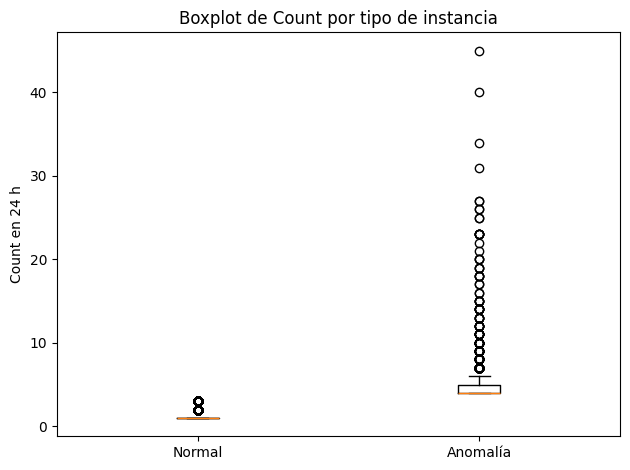

In [31]:
plt.figure()
# prepara dos listas: counts normales y counts anómalos
normal = sample_pd.loc[~sample_pd['if_anom'], 'count_amt']
anom   = sample_pd.loc[ sample_pd['if_anom'], 'count_amt']

plt.boxplot([normal, anom], labels=['Normal','Anomalía'])
plt.title('Boxplot de Count por tipo de instancia')
plt.ylabel('Count en 24 h')
plt.tight_layout()
plt.show()


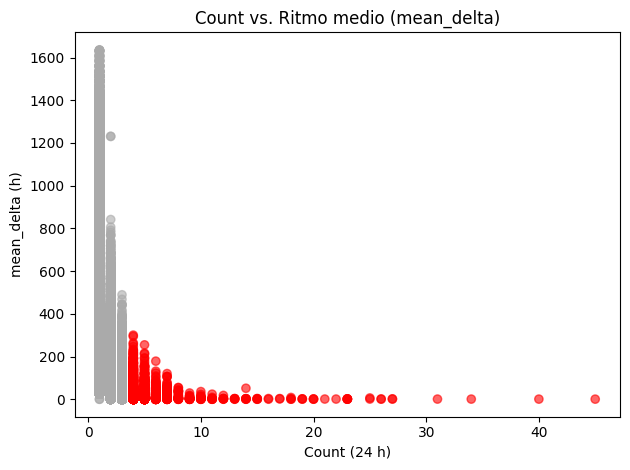

In [32]:
plt.figure()
# asigna colores: rojo para anomalías, gris para normales
colors = sample_pd['if_anom'].map({False:'#aaa', True:'r'})

plt.scatter(
    sample_pd['count_amt'],
    sample_pd['mean_delta'],
    c=colors,
    alpha=0.6
)
plt.title('Count vs. Ritmo medio (mean_delta)')
plt.xlabel('Count (24 h)')
plt.ylabel('mean_delta (h)')
plt.tight_layout()
plt.show()

Claramente los delta de tiempos van disminuyendo a medida que que se hacen más transacciones, el color rojo nos inidica los datos atipicos.

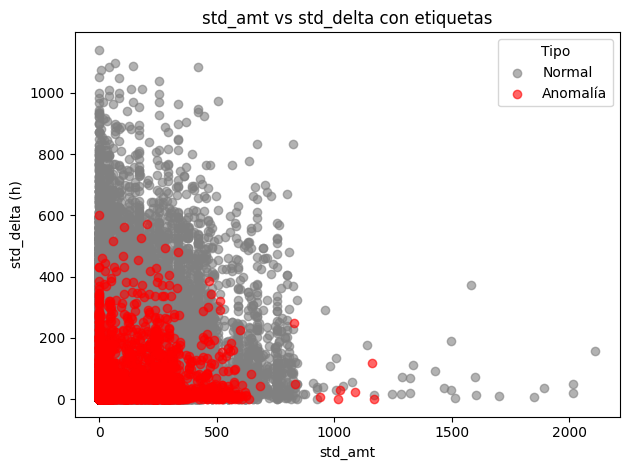

In [33]:
import matplotlib.pyplot as plt

# Define los colores y etiquetas
colors = {False: 'grey', True: 'red'}
labels = {False: 'Normal', True: 'Anomalía'}

plt.figure()
for is_anom in [False, True]:
    subset = sample_pd[sample_pd['if_anom'] == is_anom]
    plt.scatter(
        subset['std_amt'],
        subset['std_delta'],
        c=colors[is_anom],
        alpha=0.6,
        label=labels[is_anom]
    )

plt.title('std_amt vs std_delta con etiquetas')
plt.xlabel('std_amt')
plt.ylabel('std_delta (h)')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()


Algo que también es de esperarse es que las variabilidades de los montos y de los tiempos sean pequeñas en las transacciones fraccionadas, ya que si los montos son los mismos, la variabilidad tiende a ser muy pequeño y lo mismo en los tiempos, si la diferencia de tiempos entre las transacciones son los mismos entonces la variabilidad tiende a ser también pequeño.

## Detección de anomalías multivariadas con Local Outlier Factor (LOF)

En esta sección aplicamos **Local Outlier Factor** para identificar ventanas móviles de 24 h con comportamiento transaccional inusual, basándonos en densidad local de cada punto.

1. **Preparación de la matriz de features**  
   - Extrajimos seis variables por ventana:  
     - `count_amt`: número de transacciones  
     - `sum_amt`: suma de montos  
     - `mean_amt` / `std_amt`: media y desviación de montos  
     - `mean_delta` / `std_delta`: media y desviación de los lapsos inter-transacción  
   - Rellenamos valores faltantes con cero para garantizar consistencia numérica.

2. **Instanciación del modelo LOF**  
   - `n_neighbors`: tamaño de la vecindad local (p.ej. 20)  
   - `contamination`: proporción estimada de outliers (p.ej. 1 %)  
   - `metric='euclidean'` para distancia estándar en el espacio de features  

3. **Entrenamiento y etiquetado**  
   - Con `fit_predict` ajustamos el modelo sobre la muestra de datos y obtenemos para cada ventana la etiqueta:  
     - `1` → inlier (dato normal)  
     - `-1` → outlier (dato anómalo)  

4. **Cálculo del score continuo**  
   - `negative_outlier_factor_` devuelve un valor de densidad relativa; los valores más negativos indican mayor probabilidad de anomalía.

5. **Integración de resultados**  
   - Añadimos al DataFrame las columnas:  
     - `lof_score` (score continuo)  
     - `lof_anom` (booleano de anomalía)  

6. **Inspección e interpretación**  
   - Revisamos algunos casos con sus scores y etiquetas para validar que LOF marca correctamente ventanas con patrones de densidad inusuales.  
   - Opcionalmente, comparamos gráficamente `lof_score` o cruzamos `count_amt` vs. `mean_delta` coloreando por `lof_anom` para visualizar las regiones de baja densidad.

> **Nota:** LOF es especialmente útil cuando los outliers aparecen en regiones de baja densidad dentro del espacio de características, capturando anomalías que no necesariamente están aisladas en cortes aleatorios como en Isolation Forest.  


In [22]:
#    Prepara la matriz X igual que antes, con tu feature numérica:
#    count_amt
X = sample_pd[["count_amt"]].fillna(0).values

# 2) Instancia LOF
#    - n_neighbors: controla el tamaño de la vecindad (p.ej. 20)
#    - contamination: proporción esperada de outliers (p.ej. 1%)
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.01,
    metric='euclidean',
    novelty=False           # novelty=False para detección en training
)

# 3) Ajusta y predice en un paso con fit_predict
labels = lof.fit_predict(X)
#    etiquetas:  1 → inlier,  -1 → outlier

# 4) Score de anomalía continua
scores = lof.negative_outlier_factor_
#    valores más negativos → más anómalo

# 5) Añade resultados al DataFrame
sample_pd['lof_anom']  = (labels == -1)
sample_pd['lof_score'] = scores

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [36]:
sample_pd[sample_pd['lof_anom'] == True].describe()

,transaction_date,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta,lof_score
count,66,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,6.600000e+01
mean,2021-03-20 13:15:04.393939456,17.787879,1256.881157,94.748946,29.226742,3.108692,10.002123,-8.333333e+08
min,2021-03-01 17:24:35,11.000000,77.277915,5.944455,0.000000,0.026181,0.052789,-5.500000e+09
25%,2021-03-04 17:15:51.249999872,12.250000,156.041944,8.335160,2.102744,0.900096,1.928948,-1.241269e+00
50%,2021-03-09 16:00:58,15.000000,300.789424,12.954280,5.634697,1.401651,3.658966,-1.138439e+00
75%,2021-03-17 18:17:11.500000,21.750000,530.899277,38.568705,26.485226,2.183768,6.417012,-1.061837e+00
max,2021-06-09 09:50:38,45.000000,11294.464523,1026.769502,285.562382,51.529921,191.512745,-1.041830e+00
std,NaN,7.067836,2422.595488,199.775904,58.753142,7.114081,26.185753,1.987138e+09


In [37]:
sample_pd[sample_pd['lof_anom'] == False].describe()

,transaction_date,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta,lof_score
count,330915,330915.000000,330915.000000,330915.000000,44314.000000,204105.000000,34556.000000,330915.0
mean,2021-05-05 13:40:17.902802688,1.175531,255.469056,200.193519,118.543006,201.139957,105.216811,-1.0
min,2021-03-01 00:06:51,1.000000,5.944455,5.944455,0.000000,0.000000,0.000000,-1.0
25%,2021-04-05 10:58:49,1.000000,59.444550,47.555640,8.406729,47.904167,17.033318,-1.0
50%,2021-05-08 12:02:40,1.000000,118.889100,118.889100,50.440373,118.016389,52.003775,-1.0
75%,2021-06-05 13:13:28,1.000000,297.222751,249.667111,176.541307,265.473611,135.753994,-1.0
max,2021-06-30 23:56:28,10.000000,11377.686894,3210.005707,2110.088954,1636.132778,1140.125618,-1.0
std,NaN,0.521917,388.172314,224.531700,153.096087,229.984235,137.185238,0.0


Note usando Local Outlier Factor, una transacción es inusual si supera las 11 transacciones en una ventana de 24 horas, lo que nos deja una regla un poco más estricta a la hora de clasificar las transacciones fraccionadas por lo que esta regla podria no detectar transacciones fraccionadas por este valor tan alto, la verdad muy diferente a lo que hemos visto en otros modelos.

/tmp/ipython-input-38-2823928468.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal, anom], labels=['Normal','Anomalía'])


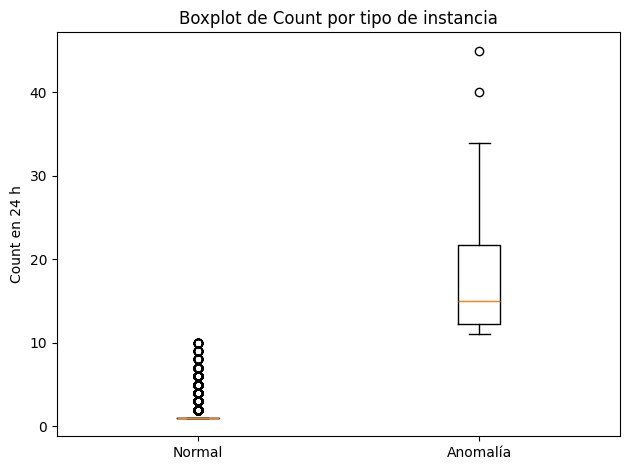

In [38]:
plt.figure()
# prepara dos listas: counts normales y counts anómalos
normal = sample_pd.loc[~sample_pd['lof_anom'], 'count_amt']
anom   = sample_pd.loc[ sample_pd['lof_anom'], 'count_amt']

plt.boxplot([normal, anom], labels=['Normal','Anomalía'])
plt.title('Boxplot de Count por tipo de instancia')
plt.ylabel('Count en 24 h')
plt.tight_layout()
plt.show()


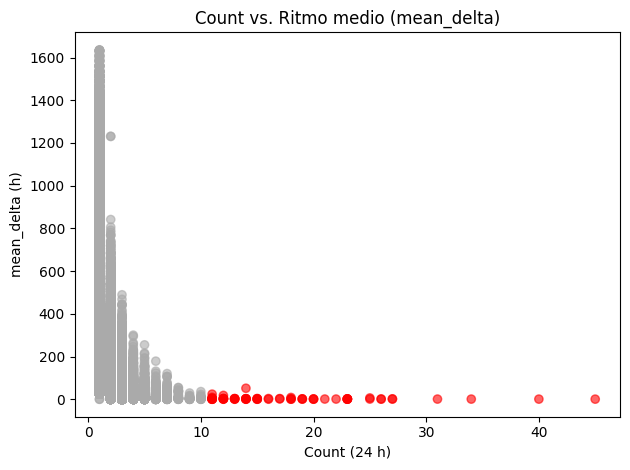

In [39]:
plt.figure()
# asigna colores: rojo para anomalías, gris para normales
colors = sample_pd['lof_anom'].map({False:'#aaa', True:'r'})

plt.scatter(
    sample_pd['count_amt'],
    sample_pd['mean_delta'],
    c=colors,
    alpha=0.6
)
plt.title('Count vs. Ritmo medio (mean_delta)')
plt.xlabel('Count (24 h)')
plt.ylabel('mean_delta (h)')
plt.tight_layout()
plt.show()

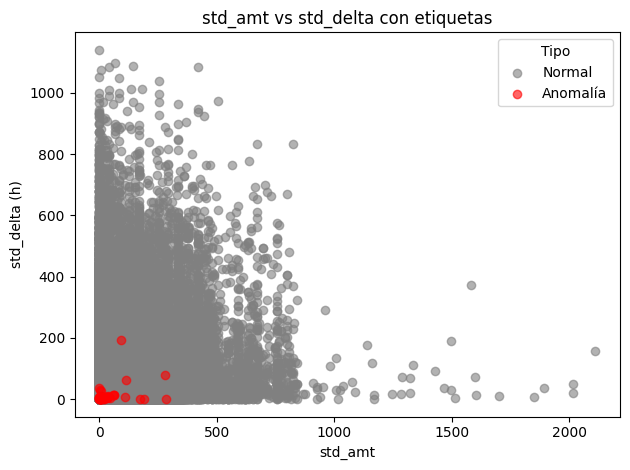

In [40]:
import matplotlib.pyplot as plt

# Define los colores y etiquetas
colors = {False: 'grey', True: 'red'}
labels = {False: 'Normal', True: 'Anomalía'}

plt.figure()
for is_anom in [False, True]:
    subset = sample_pd[sample_pd['lof_anom'] == is_anom]
    plt.scatter(
        subset['std_amt'],
        subset['std_delta'],
        c=colors[is_anom],
        alpha=0.6,
        label=labels[is_anom]
    )

plt.title('std_amt vs std_delta con etiquetas')
plt.xlabel('std_amt')
plt.ylabel('std_delta (h)')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()

Se sigue observando el mismo comportamiento aunque un poco más estrictos para clasificar estos datos que no son normales o atipicos como ya lo aviamos mencionado.

In [42]:
#sample_pd.to_csv('sample_pd.csv', index=False)

Note que los modelos anteriores, por su naturaleza de encontrar datos atípicos, no tuve en cuenta muchas características después de hacer feature engineering por razones que mencioné previamente, por eso a continuación vamos a usar algoritmos no supervisados para encontrar clústeres que me permitan dadas las características de las agrupaciones de las transacciones decidir y clasificar cuáles son transacciones fraccionadas y cuáles no.

## Detección de clusters sospechosos con DBSCAN

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) agrupa instancias basándose en su densidad local. Para cada punto, busca vecinos dentro de un radio `eps` y exige al menos `min_samples` vecinos para formar un cluster. Los puntos que no alcanzan esa densidad se marcan como “ruido”.

1. **Feature utilizada**  
   – `count_amt`
   Estas seis variables resumen el volumen y el ritmo de transacciones en cada ventana de 24 h.

2. **Escalado**  
   Normalizamos todas las variables a media 0 y varianza 1 con `StandardScaler` para equilibrar las distancias.

3. **Parámetros de DBSCAN**  
   – `eps=1.8`: radio de vecindad en unidades escaladas  
   – `min_samples=10`: número mínimo de ventanas para formar un cluster

4. **Entrenamiento y etiquetado**  
   Con `fit_predict` obtenemos `dbscan_cluster`:  
   – Clusters (valores ≥ 0)  
   – Ruido (`-1`)

5. **Análisis**  
   – Conteo de clusters vs. ruido  
   – Ejemplos de ventanas dentro de un cluster y de ventanas aisladas  
   – Interpretación: los clusters densos pueden indicar patrones coordinados de fraccionamiento, y el ruido suele ser actividad dispersa o legítima.

> **Nota:** DBSCAN no requiere conocer el número de clusters por adelantado y es robusto al ruido. Ajustar `eps` y `min_samples` permite capturar estructuras de densidad en el espacio multivariado de tus features.  


In [2]:
#sample_pd = pd.read_csv('sample_pd.csv')

Debido a la alta cantidad de datos, me vi obligado a tomar una muestra de la información, ya que el este algoritmo captura estructuras de densidades en un espacio multivariado para cada vector o dato. Esto hace que almacene mucha información en memoria durante el entrenamiento, por eso vamos a tomar una muestra representativa que me permita seguir teniendo la misma variabilidad de información pero con menos datos.

In [11]:
sample_pd2 = sample_pd.sample(frac=0.1, random_state=42)

In [34]:
features = ['count_amt','sum_amt','mean_amt','std_amt','mean_delta','std_delta']
X = sample_pd2[features].fillna(0).values

# Escalado de las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configuración y entrenamiento de DBSCAN
#    Ajusta eps y min_samples según densidad esperada
db = DBSCAN(eps=1.8, min_samples=10, metric='euclidean')
labels = db.fit_predict(X_scaled)

# Asignación de etiquetas al DataFrame
sample_pd2['dbscan_cluster'] = labels

# Resumen de clusters y ruido
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = np.sum(labels == -1)
print(f"Clusters formados: {n_clusters}, ventanas aisladas (ruido): {n_noise}")

Clusters formados: 2, ventanas aisladas (ruido): 191


In [42]:
sample_pd2["dbscan_cluster"].value_counts()

,count
dbscan_cluster,
0,32881
-1,191
1,26


El clúster -1 son datos que no se acomodaron a ningún clúster por eso se le llama ruido en este algoritmo, a continuación veremos cómo se comportan o qué características tienen estos dos clústeres encontrados con
DBSCAN.


In [41]:
sample_pd2[sample_pd2["dbscan_cluster"]==0].describe()

,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta,lof_score,dbscan_cluster
count,32881.000000,32881.000000,32881.000000,4285.000000,20205.000000,3327.000000,32881.0,32881.0
mean,1.161613,242.682424,197.458481,109.641909,201.967858,94.979970,-1.0,0.0
std,0.461906,329.605645,216.960180,139.576052,230.200869,117.122116,0.0,0.0
min,1.000000,5.944455,5.944455,0.000000,0.000278,0.000000,-1.0,0.0
25%,1.000000,59.444550,47.555640,8.406729,47.951111,17.213238,-1.0,0.0
50%,1.000000,118.889100,118.889100,50.440373,118.465000,51.093965,-1.0,0.0
75%,1.000000,297.222751,249.667111,168.134578,265.395278,125.376645,-1.0,0.0
max,7.000000,3328.894807,1902.225604,832.266161,1632.393333,808.243675,-1.0,0.0


In [40]:
sample_pd2[sample_pd2["dbscan_cluster"]==1].describe()

,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta,lof_score,dbscan_cluster
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.0
mean,5.038462,3114.894426,619.381728,110.005994,11.223871,22.769841,-1.0,1.0
std,0.196116,359.839423,77.319885,107.055210,16.195283,34.512330,0.0,0.0
min,5.000000,2508.560015,467.630461,0.000000,0.015000,0.002257,-1.0,1.0
25%,5.000000,2886.032908,577.206582,0.000000,0.038455,0.022164,-1.0,1.0
50%,5.000000,3013.838691,602.767738,101.653205,5.289118,9.792786,-1.0,1.0
75%,5.000000,3536.950732,707.390146,194.224911,19.471736,35.230444,-1.0,1.0
max,6.000000,3566.673007,713.334601,292.428521,57.445222,128.419900,-1.0,1.0


Estos resultados son satisfactorios y concuerdan con lo que hemos visto durante todo este análisis para detectar transacciones fraccionadas.

Observe que en el clúster número 0 el promedio de número de transacciones es de 1.16 lo que ya sabemos que son transacciones comunes y corrientes y esto lo hemos visto durante todo este análisis, este clúster son transacciones que no mueven mucho monto, ya que en promedio mueven  242.682424 en la suma, la variabilidad de tiempo es alta (Desv. 94.97) y esto es normal en personas que hacen transacciones no tan seguidas y los lapsos de tiempos son amplios, también la variabilidad de los montos son amplios (Desv. 201.96) y esto indica que los montos no son de los mismos valores entre transacciones, lo que también nos da indicio de que no son transacciones fraccionadas.

Ahora observamos las características del clúster 1, en promedio hacen 5.03 transacciones y, dado lo que hemos visto durante todo este análisis, este va siendo valores atípicos donde podrían estar transacciones fraccionadas. Este clúster mueve más monto de lo normal entre las transacciones, se observa que en promedio la suma de los montos es de aproximadamente 3114.9 y esto concuerda con mi hipótesis que vi en el histograma de la distribución bimodal anteriormente, donde se observaba dos poblaciones donde uno movía muchas veces poco dinero y otro muchas veces mucho más dinero, esto es lo que estamos observando en estos dos clústeres. Observe que la variabilidad en el tiempo es baja (Desv 22.76) y tiene sentido porque las transacciones fraccionadas son en intervalos cerca del tiempo y similares entre sí, también observe que la variabilidad entre los montos es baja (Desv  11.22) lo que nos indica que el valor entre los montos son similares y esto nos señala que son transacciones fraccionadas

Con este resultado tenemos una regla de decisión bastante buena para clasificar transacciones fraccionadas ya que podriamos tomar que los nuevos datos que esten cercanos al clúster 1 son este tipo de transacciones.

## Modelo de Mezcla Gaussiana (GMM) para detección de patrones

El modelo de mezcla gaussiana (GMM) es una técnica probabilística para modelar datos como una combinación de varias distribuciones normales. En lugar de asumir que los datos pertenecen a un solo grupo definido (como en K-Means), GMM estima la probabilidad de que cada punto pertenezca a **cada uno de los grupos**.

---


### Parámetros importantes

- `n_components`: número de componentes (grupos) gaussianos a mezclar
- `covariance_type`: tipo de covarianza (por defecto `'full'`)
- `random_state`: asegura resultados reproducibles

---

### Interpretación

Después del entrenamiento, cada transacción queda asociada a:

- `gmm_cluster`: grupo al que pertenece (según mayor probabilidad)
- `gmm_score`: confianza del modelo en que el punto realmente pertenece al grupo

> **Transacciones con baja probabilidad (`gmm_score < 0.6`) pueden ser consideradas atípicas**, ya que el modelo no logra asignarlas con seguridad a ningún grupo.

---

### Ventajas

- Maneja **grupos con diferentes formas y tamaños**
- Asigna **probabilidades** en lugar de decisiones duras (mayor flexibilidad)
- Adecuado para detectar **comportamientos raros** dentro de patrones conocidos

---

### Aplicación en este proyecto

Se utilizó GMM para modelar patrones de comportamiento en ventanas móviles de transacciones, usando variables como:

- Número de transacciones
- Monto total y promedio
- Desviación estándar
- Tiempo promedio entre transacciones (`delta`)


In [72]:
# Variables
features = ['count_amt', 'sum_amt', 'std_delta', 'mean_delta','std_amt', 'mean_amt']
X = sample_pd[features].fillna(0).values

# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entrenamos el modelo GMM con 3 componentes (puedes ajustar este número)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

# Predicciones: a qué componente pertenece cada punto
labels = gmm.predict(X_scaled)

# Probabilidad de pertenencia a su componente
probs = gmm.predict_proba(X_scaled).max(axis=1)

# Guardamos los resultados
sample_pd['gmm_cluster'] = labels
sample_pd['gmm_score'] = probs


In [73]:
sample_pd["gmm_cluster"].value_counts()

,count
gmm_cluster,
1,286597
0,44384


In [74]:
sample_pd[sample_pd["gmm_cluster"]==1].describe()

,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta,lof_score,gmm_cluster,gmm_score
count,286597.0,286597.000000,286597.000000,0.0,159792.000000,0.0,2.865970e+05,286597.0,2.865970e+05
mean,1.0,186.317794,186.317794,NaN,239.493297,NaN,-6.341932e+07,1.0,1.000000e+00
std,0.0,213.498718,213.498718,NaN,241.944556,NaN,2.049185e+09,0.0,3.350857e-14
min,1.0,5.944455,5.944455,NaN,0.000000,NaN,-4.659857e+11,1.0,1.000000e+00
25%,1.0,47.555640,47.555640,NaN,71.416042,NaN,-1.030793e+00,1.0,1.000000e+00
50%,1.0,118.889100,118.889100,NaN,148.269167,NaN,-1.000000e+00,1.0,1.000000e+00
75%,1.0,237.778200,237.778200,NaN,318.789514,NaN,-1.000000e+00,1.0,1.000000e+00
max,1.0,3210.005707,3210.005707,NaN,1636.132778,NaN,-8.869976e-01,1.0,1.000000e+00


In [75]:
sample_pd[sample_pd["gmm_cluster"]==0].describe()

,count_amt,sum_amt,mean_amt,std_amt,mean_delta,std_delta,lof_score,gmm_cluster,gmm_score
count,44384.000000,44384.000000,44384.000000,44380.000000,44379.000000,34622.000000,4.438400e+04,44384.0,44384.0
mean,2.333679,703.482698,289.635248,118.410179,62.749567,105.035303,-3.041511e+05,0.0,1.0
std,0.987019,779.477391,269.033940,153.037435,90.005741,137.122023,4.701095e+07,0.0,0.0
min,1.000000,11.888910,5.944455,0.000000,0.000278,0.000000,-8.618573e+09,0.0,1.0
25%,2.000000,154.555830,71.333460,8.406729,10.984792,16.950774,-1.186537e+00,0.0,1.0
50%,2.000000,416.111851,178.333650,50.440373,26.260833,51.859403,-1.054870e+00,0.0,1.0
75%,2.000000,1034.335172,475.556401,176.541307,76.007917,135.581293,-1.002277e+00,0.0,1.0
max,45.000000,11377.686894,3210.005707,2110.088954,1230.844444,1140.125618,-8.926074e-01,0.0,1.0


Pienso que estos resultados de estos clústeres tienden a parecerse un poco solo con muy leves diferencias, Observé que en promedio de transacciones en el clúster 0 son de 2.3 y del clúster 1 son de 1.0, en los análisis univariados observamos que los datos anormales son de 4 hacia arriba y hacer dos transacciones a una misma cuenta se puede considerar normal por lo que no veo reflejado en este clúster lo que hemos evidenciado en los análisis, la suma de los montos en el clúster 0 sí son más grandes que el clúster 1, pero tampoco coincide que lo que hemos visto durante los análisis, ya que en las transacciones fraccionadas suelen ser montos un poco más altos.

## Conclusión

Luego de este proceso riguroso donde analizamos, exploramos y modelamos la información de las transacciones, tenemos una idea mucho más clara de cómo es el comportamiento de las transacciones fraccionadas y de su naturaleza, de todos los modelos univariados y multivariados que construimos, a pesar de que algunos son válidos, escogería el modelo que construimos con el algoritmo no supervisado DBSCAN para detección de Clústeres, donde dada las características de este algoritmo, encontramos un clúster con todas cualidades que observamos en los análisis exploratorios y los criterios que fuimos encontrando para clasificar las transacciones fraccionadas, con este modelo todo dato que se encuentre dentro del clúster número 1 será tomado como transacción fraccionada y se podrá clasificar allí.


**¿Cada cuánto se deben actualizar los datos?**   
Deben ser por Micro-lotes, mis rolling windows de 24 h se desplazan a cada instante, pero para ponerlo en producción sin necesidad de un sistema de streaming sofisticado, un disparador que ejecute el proceso cada hora captura casi en “tiempo real” cualquier acumulación inusual sin generar excesiva carga. Una frecuencia de 1 h permite, sobre esa misma base de datos, recalcular todas las métricas (conteo, suma, media, desviación) en ventanas de “últimas 24 h” con un desfase máximo de 60 min.

**¿Qué arquitectura diseñaría y qué recursos utilizaría para desplegar mi propuesta?**  



En lo personal me siento un poco más familiarizado con AWS, así que llevaría mi solución a producción usando gran parte de sus servicios:

#### 1. Ingestión y disparo de micro-lotes  
- Primero, monto un bucket en **Amazon S3 (raw/transactions/)** donde los archivos CSV o Parquet de transacciones llegan continuamente.  
- Luego, configuro **Amazon EventBridge** con una regla “HourlyTrigger” para programar el disparo cada hora y poner en marcha el pipeline.

#### 2. Orquestación y procesamiento cada hora  
- Uso una función **AWS Lambda “HourlyOrchestrator”** que:  
  1. Revisa qué archivos nuevos llegaron a `raw/transactions/` desde la última ejecución.  
  2. Lanza el **Glue Job “ProcessLastHour”** con la ventana de datos de la última hora.  
- En el **Glue Job (Spark)**, paso a paso:  
  1. **Carga** todas las transacciones de la última hora desde S3.  
  2. Realizo la **ingeniería de características** calculando ventanas móviles (rolling windows): conteo, suma, media, desviación estándar y deltas de tiempo.  
  3. Ejecuto mi **modelo de clustering** (DBSCAN) para etiquetar cada “usuario–comercio–ventana” como normal o anómalo.  
  4. Guardo en staging (S3, Redshift o RDS) las etiquetas de clúster, puntuaciones de anomalía y flags.

#### 3. Almacenamiento de resultados y histórico horario  
- En **Amazon Redshift** (o **RDS PostgreSQL**) mantengo:  
  - **alertas_horarias**: Aquí se guarda el clúster asignado con marca de tiempo por cada hora y demás información.  
  - **características_horarias**: histórico de todas las métricas calculadas para auditoría y monitoreo.

#### 4. Batch diario y generación de tablero  
- Configuro otra regla en **EventBridge** para disparar cada tiempo especifico.  
- Esa ejecución lanza el **Lambda/Glue “DailyAggregator”** que:  
  1. Lee los datos de las últimas 24 h de alertas_horarias y características_horarias.  
  2. Genera la distribución de clústeres resultantes del modelo.  
  3. Actualiza vistas materializadas para reporting.  
- Finalmente, en **Amazon QuickSight** diseño un dashboard con alertas horarias vs. diarias, tendencias de clústeres y evolución mensual, de modo que el equipo de riesgos y de negocio tenga visibilidad inmediata.

---

De esta forma, el modelo de clustering se alimenta con datos cada hora (micro-lotes).


Muchas gracias, fue una prueba técnica muy interesante.  
Atentamente: Brahian Serna